In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


import sys
sys.path.append("..")
from utils_image import compute_zpos_sp, get_meanZstack
from utils_analysis import plot_trajectory, getTuningMap, getTuningMap_shuffle
from utils_fluorescence import get_deltaF_F_and_fr
from scanimagetiffio import SITiffIO

### 0, set path

In [2]:
superficial_folder_27 = "/media/zilong/4TB Storage HDD/2PImaging/183_27072023"
superficial_namelist_27 = ["00003", "00004", "00005", "00006", "00007", "00008", "00009", "00012", "00013", "00014", "00018"]

deep_folder_28 = "/media/zilong/4TB Storage HDD/2PImaging/183_28072023"
deep_namelist_28 = ["00002", "00003", "00004", "00005", "00006", "00007", "00008", "00010", "00013", "00015", "00016"]

deep_folder_31 = "/media/zilong/4TB Storage HDD/2PImaging/183_31072023"
deep_namelist_31 = ["00001", "00003", "00005", "00006", "00007", "00008", "00009", "00010", "00013", "00014"]

# test_folder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
# test_namelist = ["00004", "00005", "00006", "00007", "00008", "00009", "00010", "00012", "00014", "00016", "00017", "00018"]



### 1, get the mean registrated images

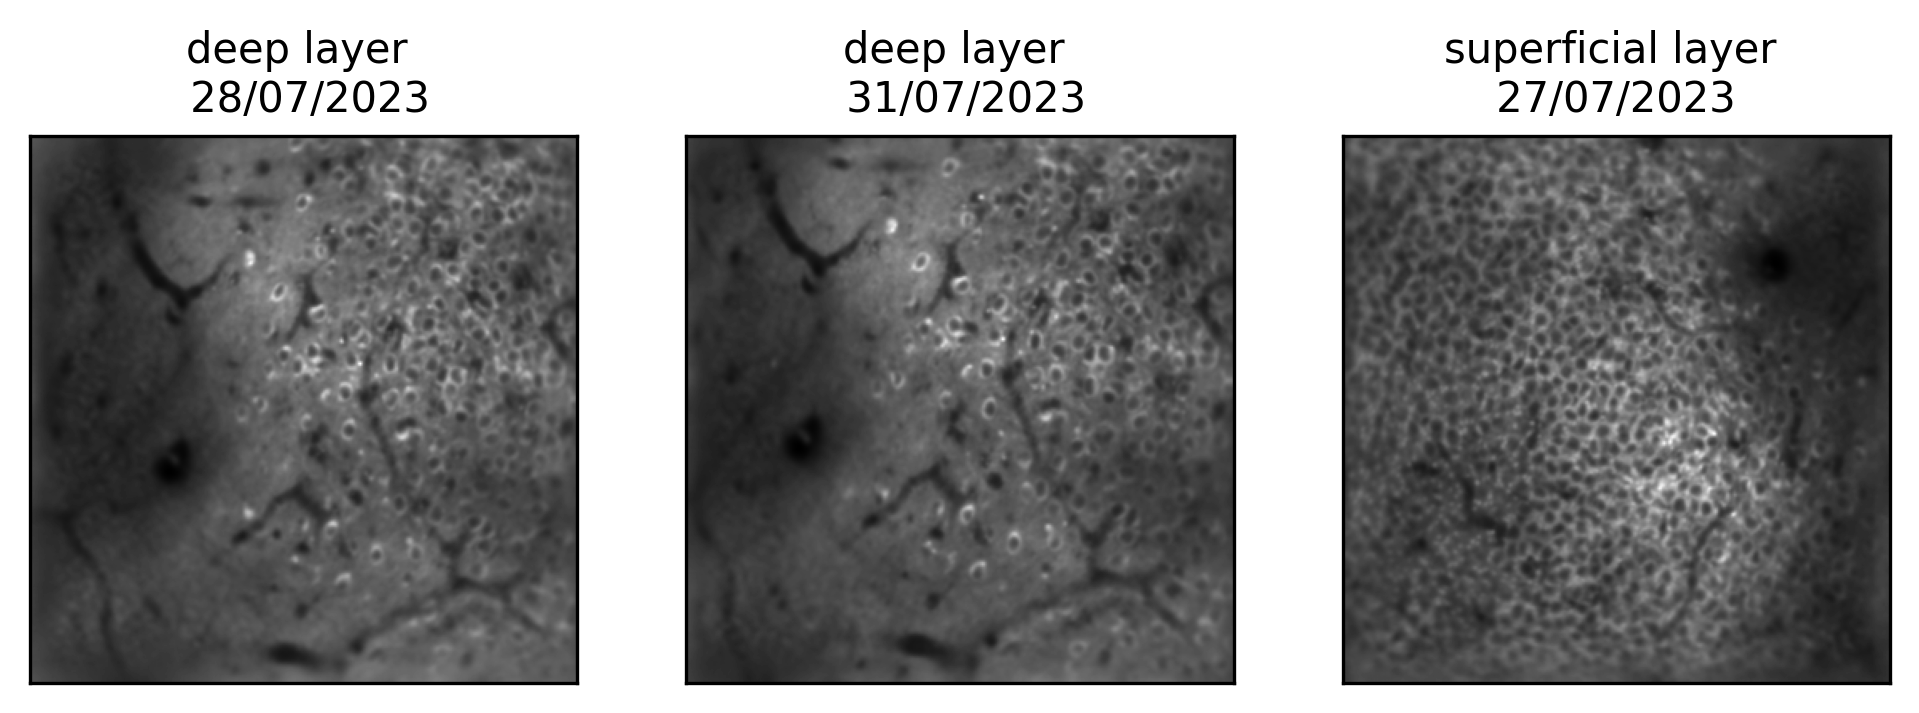

In [17]:
ops =  np.load(os.path.join(superficial_folder_27, 'UnrotTiff/suite2p/plane0', 'ops.npy'), allow_pickle=True).item()
deep_meanIm = ops['meanImg']

ops =  np.load(os.path.join(deep_folder_28, 'UnrotTiff/suite2p/plane0', 'ops.npy'), allow_pickle=True).item()
superf_meanIm_28 = ops['meanImg']

ops =  np.load(os.path.join(deep_folder_31, 'UnrotTiff/suite2p/plane0', 'ops.npy'), allow_pickle=True).item()
superf_meanIm_31 = ops['meanImg']

#plot the mean images in s 1*3 subplots with x y ticks off
fig = plt.figure(figsize=(8, 3), dpi=300)
gs = GridSpec(1, 3, figure=fig)
labelsize = 10
ticksize = 8

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(superf_meanIm_28, cmap='gray')
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_title("deep layer \n 28/07/2023", fontsize=labelsize)

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(superf_meanIm_31, cmap='gray')
ax2.set_xticks([]); ax2.set_yticks([])
ax2.set_title("deep layer \n 31/07/2023", fontsize=labelsize)

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(deep_meanIm, cmap='gray')
ax3.set_xticks([]); ax3.set_yticks([])
ax3.set_title("superficial layer \n 27/07/2023 ", fontsize=labelsize)

#save the figure
savefolder = os.path.join(superficial_folder_27, 'UnrotTiff/2D2P')
if not os.path.exists(savefolder):
    os.makedirs(savefolder)
    
fig.savefig(os.path.join(savefolder, 'meanIm_deep_vs_superficial.pdf'), dpi=300, bbox_inches='tight')




### 2, get the tuning maps in different layers

In [7]:
#define a function to do this

def get_potentialPC_tuningmaps(data_folder, namelist):
    
    
    ####################### 
    #1, get the trajectory#
    #######################
    print('1, get the trajectory...') 
       
    #if trajectory is already saved in pickle file, load it
    if os.path.exists(os.path.join(data_folder,'UnrotTiff', '2D2P','trajectory.pickle')):
        with open(os.path.join(data_folder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
            trajectory = pickle.load(f)
        allX_sf = trajectory[0]
        allZ_sf = trajectory[1]
        allTime_sf = trajectory[2]
        allTheta_sf = trajectory[3]
    else:
        allX_sf, allZ_sf, allTime_sf, allTheta_sf, fig_sf = plot_trajectory(data_folder, namelist)

    #chnage allX and allZ from dictionary to np.array
    Traj_x_sf = np.concatenate(list(allX_sf.values()))
    Traj_z_sf = np.concatenate(list(allZ_sf.values()))
    minx_sf = np.min(Traj_x_sf); maxx_sf = np.max(Traj_x_sf)
    minz_sf = np.min(Traj_z_sf); maxz_sf = np.max(Traj_z_sf)
    #normalize x and z to [0,1]
    Traj_x_sf = (Traj_x_sf-minx_sf)/(maxx_sf-minx_sf)
    Traj_z_sf = (Traj_z_sf-minz_sf)/(maxz_sf-minz_sf)

    #concatenate the time stamps, a
    # add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
    for i in range(len(allTime_sf)):
        #chnage allTime[i] to np.array
        allTime_sf[i] = np.array(allTime_sf[i])
        if i == 0:
            timestamps_sf = allTime_sf[i]
        else:
            timestamps_sf = np.concatenate((timestamps_sf, allTime_sf[i]+timestamps_sf[-1]+0.033))

    #get the speed of the trajectory using the time stamps and the x and z coordinates
    #do not use for loop
    speed_sf = np.sqrt(np.diff(Traj_x_sf)**2+np.diff(Traj_z_sf)**2)/np.diff(timestamps_sf)
    #print mean speed
    print('    mean speed: '+str(np.mean(speed_sf)))

    ######################### 
    #2, load suite2p results#
    #########################   
    print('2, load suite2p results...') 
    
    processed_datafolder = os.path.join(data_folder, 'UnrotTiff/suite2p/plane0')
    
    #load the processed data
    spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
    #load raw fluorescence signal F and neuropil signal Fneu
    F = np.load(os.path.join(processed_datafolder, 'F.npy'), allow_pickle=True)
    Fneu = np.load(os.path.join(processed_datafolder, 'Fneu.npy'), allow_pickle=True)
    #get the neuropil corrected signal Fcorr = F-0.7*Fneu
    Fcorr = F - 0.7*Fneu

    ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
    ops = ops.item()
    iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)
    
    #get the deltaF/F and firing rate from deconvolved calcium traces and neuropil corrected signal, if not exist, calculate it
    if os.path.exists(os.path.join(processed_datafolder, 'deltaF.npy')) and os.path.exists(os.path.join(processed_datafolder, 'fr.npy')):
        deltaF = np.load(os.path.join(processed_datafolder, 'deltaF.npy'))
        fr = np.load(os.path.join(processed_datafolder, 'fr.npy'))
    else:
        deltaF, fr = get_deltaF_F_and_fr(spks, Fcorr, moving_window=15, framerate=30, percetile=8)
        #save deltaF and fr to processed_datafolder as npy file
        np.save(os.path.join(processed_datafolder, 'deltaF.npy'), deltaF)
        np.save(os.path.join(processed_datafolder, 'fr.npy'), fr)
        
    ######################### 
    #3, get the tuning maps #
    #########################       
    print('3, get the tuning maps...')
    
    savefolder = os.path.join(data_folder, 'UnrotTiff', '2D2P')
    #if Potential_PC_results.pickle exist under savefolder, load it
    #otherwise calculate the potential PC maps and save them to Potential_PC_results.pickle
    if os.path.exists(os.path.join(savefolder, 'Potential_PC_results.pickle')):
        with open(os.path.join(savefolder, 'Potential_PC_results.pickle'), 'rb') as f:
            Potential_PC_results = pickle.load(f)
    else:
        #get the index
        cell_idx = np.where(iscell[:,0]==1)[0]
        peak_thres = 0.15
        peak_up_thres = 50
        N=200 #shuffle 200 times

        #for each neuron, calculate the tuning map
        potentialPC_maps = {}
        peaks = {}
        SIC_real_all = {}
        SIC_shuffle_all = {}

        for i, key in enumerate(cell_idx):
            print('    Getting tuning map of cell '+str(key))
            
            if key == 17:
                continue
            
            results = getTuningMap(fr[key], Traj_x_sf, Traj_z_sf, timestamps_sf, 
                                   VRsize=(1,1), binsize=(0.025,0.025), sigma=3, 
                                   speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                                   peak_thres=peak_thres, cell_id = key, datafolder=data_folder, 
                                   return_all=True, apply_adaptive_binning=True)
            
            ave_calcium_in_bin_gs, ave_calcium_in_bin_raw, all_calcium_mean, prob_visit, _, _, _ = results
            
            peak_key = np.nanmax(ave_calcium_in_bin_gs)
            print('    ---peak value of cell '+str(key)+': '+str(peak_key))
            
            #filter out the maps with peak value less than peak_thres
            if peak_key<peak_thres or peak_key>peak_up_thres:
                continue           
            
            print('    Calculating spatial information content of cell '+str(key))
            #calculate the spatial information content
            SICMat_real = prob_visit*ave_calcium_in_bin_raw/all_calcium_mean*np.log2(ave_calcium_in_bin_raw/all_calcium_mean+1e-10)
            SIC_real = np.nansum(SICMat_real)

            #shuffle fr[key] by rolling it with a random number between 0 and 1000
            #and calculate the spatial information content of the shuffled data
            #do this N times
            fr_shuffle = np.zeros((N, len(fr[key])))
            for j in range(N):
                fr_shuffle[j] = np.roll(fr[key], np.random.randint(1800, len(fr[key])-1800))
            
            print('    Calculating shuffled tuning mapps of cell '+str(key))
            
            results = getTuningMap_shuffle(fr_shuffle, Traj_x_sf, Traj_z_sf, timestamps_sf, VRsize=(1,1),
                            binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                            apply_adaptive_binning=True)
            ave_calcium_in_bin_shuffle, all_calcium_mean_shuffle, prob_visit_shuffle, _, _, _ = results
            #calculate the spatial information content for shuffled data
            
            SICMat_shuffle = np.zeros((N, len(prob_visit), len(prob_visit))) 
            for j in range(N):
                SICMat_shuffle[j] = prob_visit_shuffle[j,:,:]*ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]*np.log2(ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]+1e-10)

            SIC_shuffle = np.nansum(SICMat_shuffle, axis=(1,2))

            ############################################################################################################
            #then filter the maps with SIC exceeding 95 percentile of the shuffled map
            #save them to potentialPC_maps with the key as the neuron index and value as the map
            if SIC_real > np.percentile(SIC_shuffle, 75):
                peaks[key] = peak_key
                potentialPC_maps[key] = map
                SIC_real_all[key] = SIC_real
                SIC_shuffle_all[key] = SIC_shuffle

        #save SIC_real_all, SIC_shuffle_all, and potentialPC_maps into one pickle file in savefolder
        savefolder = os.path.join(data_folder, 'UnrotTiff', '2D2P')
        Potential_PC_results = {'decov_F_peaks': peaks, 'SIC_real_all':SIC_real_all, 'SIC_shuffle_all':SIC_shuffle_all, 'potentialPC_maps':potentialPC_maps}
        with open(os.path.join(savefolder, 'Potential_PC_results.pickle'), 'wb') as f:
            pickle.dump(Potential_PC_results, f)   
    
    return Potential_PC_results

In [8]:
Potential_PC_results_superf= get_potentialPC_tuningmaps(superficial_folder_27, superficial_namelist_27)

Potential_PC_results_deep_28 = get_potentialPC_tuningmaps(deep_folder_28, deep_namelist_28)

Potential_PC_results_deep_31 = get_potentialPC_tuningmaps(deep_folder_31, deep_namelist_31)

1, get the trajectory...
    mean speed: 0.12337518637942646
2, load suite2p results...
3, get the tuning maps...
1, get the trajectory...
    mean speed: 0.15463488376606882
2, load suite2p results...
3, get the tuning maps...
1, get the trajectory...
    mean speed: 0.1340789839267495
2, load suite2p results...
3, get the tuning maps...


### 3, do statistics

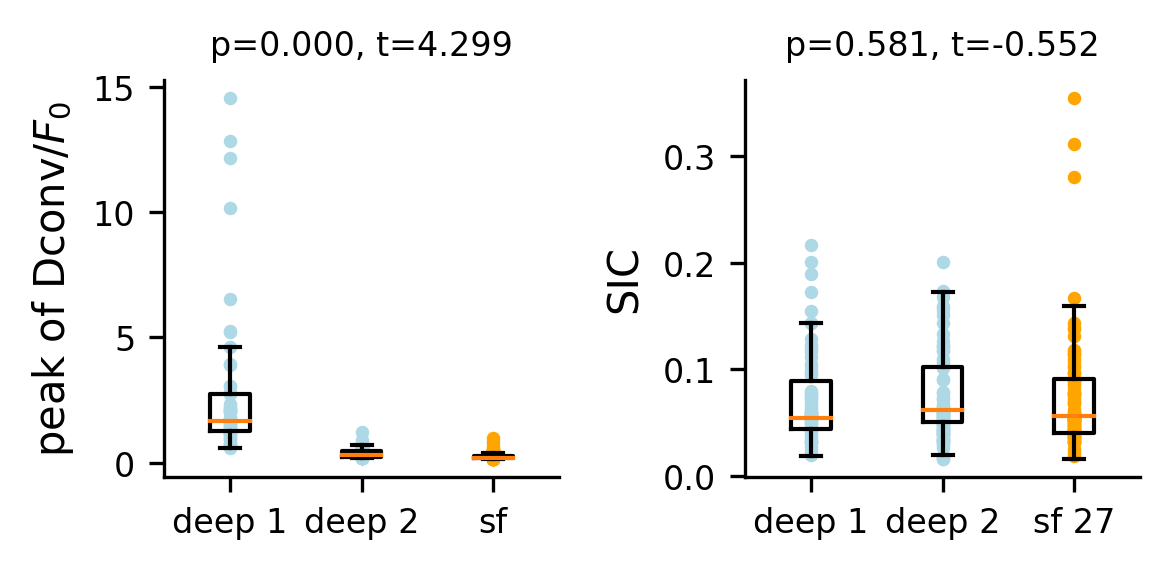

: 

In [18]:
#load Potential_PC_results.pickle for both superficial and deep layer
with open(os.path.join(superficial_folder_27, 'UnrotTiff', '2D2P', 'Potential_PC_results.pickle'), 'rb') as f:
    Potential_PC_results_sf = pickle.load(f)
    
peaks_sf = Potential_PC_results_sf['decov_F_peaks']
peaks_sf = np.array(list(peaks_sf.values()))
SIC_real_all_sf = Potential_PC_results_sf['SIC_real_all']
SIC_real_all_sf = np.array(list(SIC_real_all_sf.values()))
PC_maps_sf = Potential_PC_results_sf['potentialPC_maps']

with open(os.path.join(deep_folder_28, 'UnrotTiff', '2D2P', 'Potential_PC_results.pickle'), 'rb') as f:
    Potential_PC_results_dp_28 = pickle.load(f)

peaks_dp_28 = Potential_PC_results_dp_28['decov_F_peaks']
peaks_dp_28 = np.array(list(peaks_dp_28.values()))
SIC_real_all_dp_28 = Potential_PC_results_dp_28['SIC_real_all']
SIC_real_all_dp_28 = np.array(list(SIC_real_all_dp_28.values()))
PC_maps_dp_28 = Potential_PC_results_dp_28['potentialPC_maps']


with open(os.path.join(deep_folder_31, 'UnrotTiff', '2D2P', 'Potential_PC_results.pickle'), 'rb') as f:
    Potential_PC_results_dp_31 = pickle.load(f)

peaks_dp_31 = Potential_PC_results_dp_31['decov_F_peaks']
peaks_dp_31 = np.array(list(peaks_dp_31.values()))
SIC_real_all_dp_31 = Potential_PC_results_dp_31['SIC_real_all']
SIC_real_all_dp_31 = np.array(list(SIC_real_all_dp_31.values()))
PC_maps_dp_31 = Potential_PC_results_dp_31['potentialPC_maps']

fig = plt.figure(figsize=(4,2), dpi=300)

#do a boxplot with scatters of the peaks
ax1 = fig.add_subplot(121)
ax1.boxplot([peaks_dp_28, peaks_dp_31, peaks_sf], showfliers=False)
#add scatters
ax1.scatter(np.ones(len(peaks_dp_28))*1, peaks_dp_28, color='lightblue', s=5)
ax1.scatter(np.ones(len(peaks_dp_31))*2, peaks_dp_31, color='lightblue', s=5)
ax1.scatter(np.ones(len(peaks_sf))*3, peaks_sf, color='orange', s=5)

ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['deep 1', 'deep 2', 'sf'], fontsize=ticksize)
ax1.set_ylabel('peak of Dconv/$F_0$', fontsize=labelsize)
ax1.tick_params(axis='y', labelsize=ticksize)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#test if the three distributions are significantly different using t test
#and add p and stat to the plot as a title, keep 3 digits after decimal point
from scipy import stats
t, p = stats.ttest_ind(peaks_dp_31, peaks_sf)
ax1.set_title('p={:.3f}, t={:.3f}'.format(p, t), fontsize=ticksize)

    
#do a boxplot with scatters of the SIC
ax2 = fig.add_subplot(122)
ax2.boxplot([SIC_real_all_sf, SIC_real_all_dp_28, SIC_real_all_dp_31], showfliers=False)
#add scatters
ax2.scatter(np.ones(len(SIC_real_all_dp_28))*1, SIC_real_all_dp_28, color='lightblue', s=5)
ax2.scatter(np.ones(len(SIC_real_all_dp_31))*2, SIC_real_all_dp_31, color='lightblue', s=5)
ax2.scatter(np.ones(len(SIC_real_all_sf))*3, SIC_real_all_sf, color='orange', s=5)


ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['deep 1', 'deep 2', 'sf 27'], fontsize=ticksize)
ax2.set_ylabel('SIC', fontsize=labelsize)
ax2.tick_params(axis='y', labelsize=ticksize)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#test if the two distributions are significantly different using t test
#and add p and stat to the plot as a title, keep 3 digits after decimal point
from scipy import stats
t, p = stats.ttest_ind(SIC_real_all_dp_31, SIC_real_all_sf)
ax2.set_title('p={:.3f}, t={:.3f}'.format(p, t), fontsize=ticksize)

plt.tight_layout()

#save
savefolder = os.path.join(superficial_folder_27, 'UnrotTiff', '2D2P')
fig.savefig(os.path.join(savefolder, 'PC_comparison_peaks_and_SIC.pdf'), dpi=300)